In [1]:
import pandas as pd
import numpy as np
import geopandas

%matplotlib inline

In [2]:
url = 'https://raw.githubusercontent.com/thomaspingel/geodata/master/county_health_rankings/chr_2016.csv'
chr_df = pd.read_csv(url,dtype={'FIPS':str})
chr_df.head()

,FIPS,State,County,Premature death - # Deaths,Premature death - Years of Potential Life Lost Rate,Poor or fair health - % Fair/Poor,Poor physical health days - Physically Unhealthy Days,Poor mental health days - Mentally Unhealthy Days,Low birthweight - Unreliable,Low birthweight - # Low Birthweight Births,...,Demographics - % Native Hawaiian/Other Pacific Islander,Demographics - # Hispanic,Demographics - % Hispanic,Demographics - # Non-Hispanic White,Demographics - % Non-Hispanic White,Demographics - # Not Proficient in English,Demographics - % Not Proficient in English,Demographics - % Female,Demographics - # Rural,Demographics - % Rural
0,01001,Alabama,Autauga,809.0,9215.1,19.4,4.4,4.3,NaN,407.0,...,0.101092,1514.0,2.733099,41877.0,75.597076,249.0,0.481429,51.362036,22921.0,42.002162
1,01003,Alabama,Baldwin,2506.0,7454.6,16.0,4.1,4.2,NaN,1300.0,...,0.063964,9130.0,4.562468,166093.0,83.000435,2571.0,1.429898,51.228568,77060.0,42.279099
2,01005,Alabama,Barbour,410.0,8499.9,25.7,4.9,4.7,NaN,272.0,...,0.174806,1219.0,4.533790,12525.0,46.583851,549.0,2.150664,46.613605,18613.0,67.789635
3,01007,Alabama,Bibb,414.0,11007.7,22.0,4.8,4.6,NaN,221.0,...,0.128855,474.0,2.106105,16772.0,74.522350,112.0,0.521100,45.934417,15663.0,68.352607
4,01009,Alabama,Blount,876.0,8655.9,20.7,4.6,4.5,NaN,364.0,...,0.114347,5042.0,8.735425,50652.0,87.756198,954.0,1.765032,50.531021,51562.0,89.951502


In [3]:
url = 'https://raw.githubusercontent.com/thomaspingel/geodata/master/election/county_election_data_2000-2016.csv'
election_df = pd.read_csv(url,dtype={'FIPS':str})
election_df = election_df.loc[:,['FIPS','gop_minus_dem_prc_2016']]
election_df['landslide'] = 0
election_df.loc[np.abs(election_df['gop_minus_dem_prc_2016']) > 20,'landslide'] = 1

# Fix Shannon - > Oglala Lakota County Issue
#election_df.loc[election_df['FIPS']=='46113','FIPS'] = '46102'

election_df.head()

,FIPS,gop_minus_dem_prc_2016,landslide
0,01001,49.00,1
1,01003,57.16,1
2,01005,5.57,0
3,01007,55.15,1
4,01009,80.90,1


In [4]:
url = 'https://raw.githubusercontent.com/thomaspingel/geodata/master/cartographic_boundary_files/cb_2016_us_county_20m.geojson'
counties_df = geopandas.read_file(url)
counties_df.head()

,STATEFP,COUNTYFP,COUNTYNS,AFFGEOID,GEOID,NAME,LSAD,ALAND,AWATER,geometry
0,39,131,01074078,0500000US39131,39131,Pike,06,1140324458,9567612,"(POLYGON ((-83.353531 39.197585, -82.785891000..."
1,46,003,01266983,0500000US46003,46003,Aurora,06,1834813753,11201379,"(POLYGON ((-98.807771 43.935223, -98.331508 43..."
2,55,035,01581077,0500000US55035,55035,Eau Claire,06,1652211310,18848512,"(POLYGON ((-91.65045499999999 44.855951, -90.9..."
3,72,145,01804553,0500000US72145,72145,Vega Baja,13,118766803,57805868,"(POLYGON ((-66.448989 18.387214, -66.438950007..."
4,48,259,01383915,0500000US48259,48259,Kendall,06,1715747531,1496797,"(POLYGON ((-98.920147 30.13829, -98.587897 30...."


#### Merge the data

In [5]:
output_df = counties_df.merge(election_df,left_on='GEOID',right_on='FIPS',how='left')
output_df = output_df.merge(chr_df,left_on='GEOID',right_on='FIPS',how='left')

In [6]:
keep = (output_df['STATEFP']!='02') & (output_df['STATEFP']!='15') & (output_df['STATEFP']!='72')
output_df = output_df[keep]

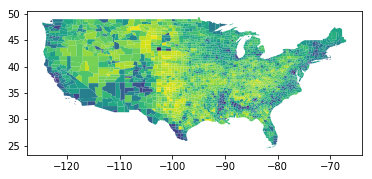

In [7]:
output_df.plot(column='gop_minus_dem_prc_2016')

#### Write out the data

In [8]:
def friendlify(s):
    s = s.replace('%','prc')
    s = s.replace('#','num')
    s = s.replace('-','_')
    s = s.replace(' ','_')
    s = s.replace('^','')
    s = s.replace('\n','')
    s = s.replace('/','_slash_')
    s = s.replace('<','lessthan')
    return s

In [9]:
for column in output_df.columns.values:
    output_df = output_df.rename(columns={column:friendlify(column)})

In [10]:
output_df['fips_as_int'] = output_df['GEOID'].astype(np.int)

In [11]:
output_df.to_file('random_forest_classification_dataset.gpkg',driver='GPKG')

CPLE_AppDefinedError: b'sqlite3_exec(CREATE VIRTUAL TABLE "rtree_random_forest_classification_dataset_geom" USING rtree(id, minx, maxx, miny, maxy)) failed: no such module: rtree'

Exception ignored in: 'fiona._shim.gdal_flush_cache'
Traceback (most recent call last):
  File "fiona/_err.pyx", line 201, in fiona._err.GDALErrCtxManager.__exit__
fiona._err.CPLE_AppDefinedError: b'sqlite3_exec(CREATE VIRTUAL TABLE "rtree_random_forest_classification_dataset_geom" USING rtree(id, minx, maxx, miny, maxy)) failed: no such module: rtree'
